# Feature Points Detection

## Load Dataset

In [1]:
import cv2
import datetime
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

In [3]:
images_path = '../data/datasets/television_dataset/images'
images = load_images_from_folder(images_path)
sample_size = 4
sequential = True
plot_dpi = 144

images_count = len(images)
if sequential:
    start = random.randint(0, images_count - sample_size)
    taken_images_index = [*range(start, start + sample_size)]
else:
    taken_images_index = random.sample(range(images_count), sample_size if images_count > sample_size else images_count)
print('Taken {} from {} images'.format(taken_images_index, images_count))

sample_images = [images[i] for i in taken_images_index]
gray_images = []

for i in taken_images_index:
    gray_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)

gray_image_index_pairs = [e for e in it.permutations(np.arange(len(gray_images)), 2)]
print('Gray image pairs: {}'.format(gray_image_index_pairs))

Taken [1, 2, 3, 4] from 40 images
Gray image pairs: [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2)]


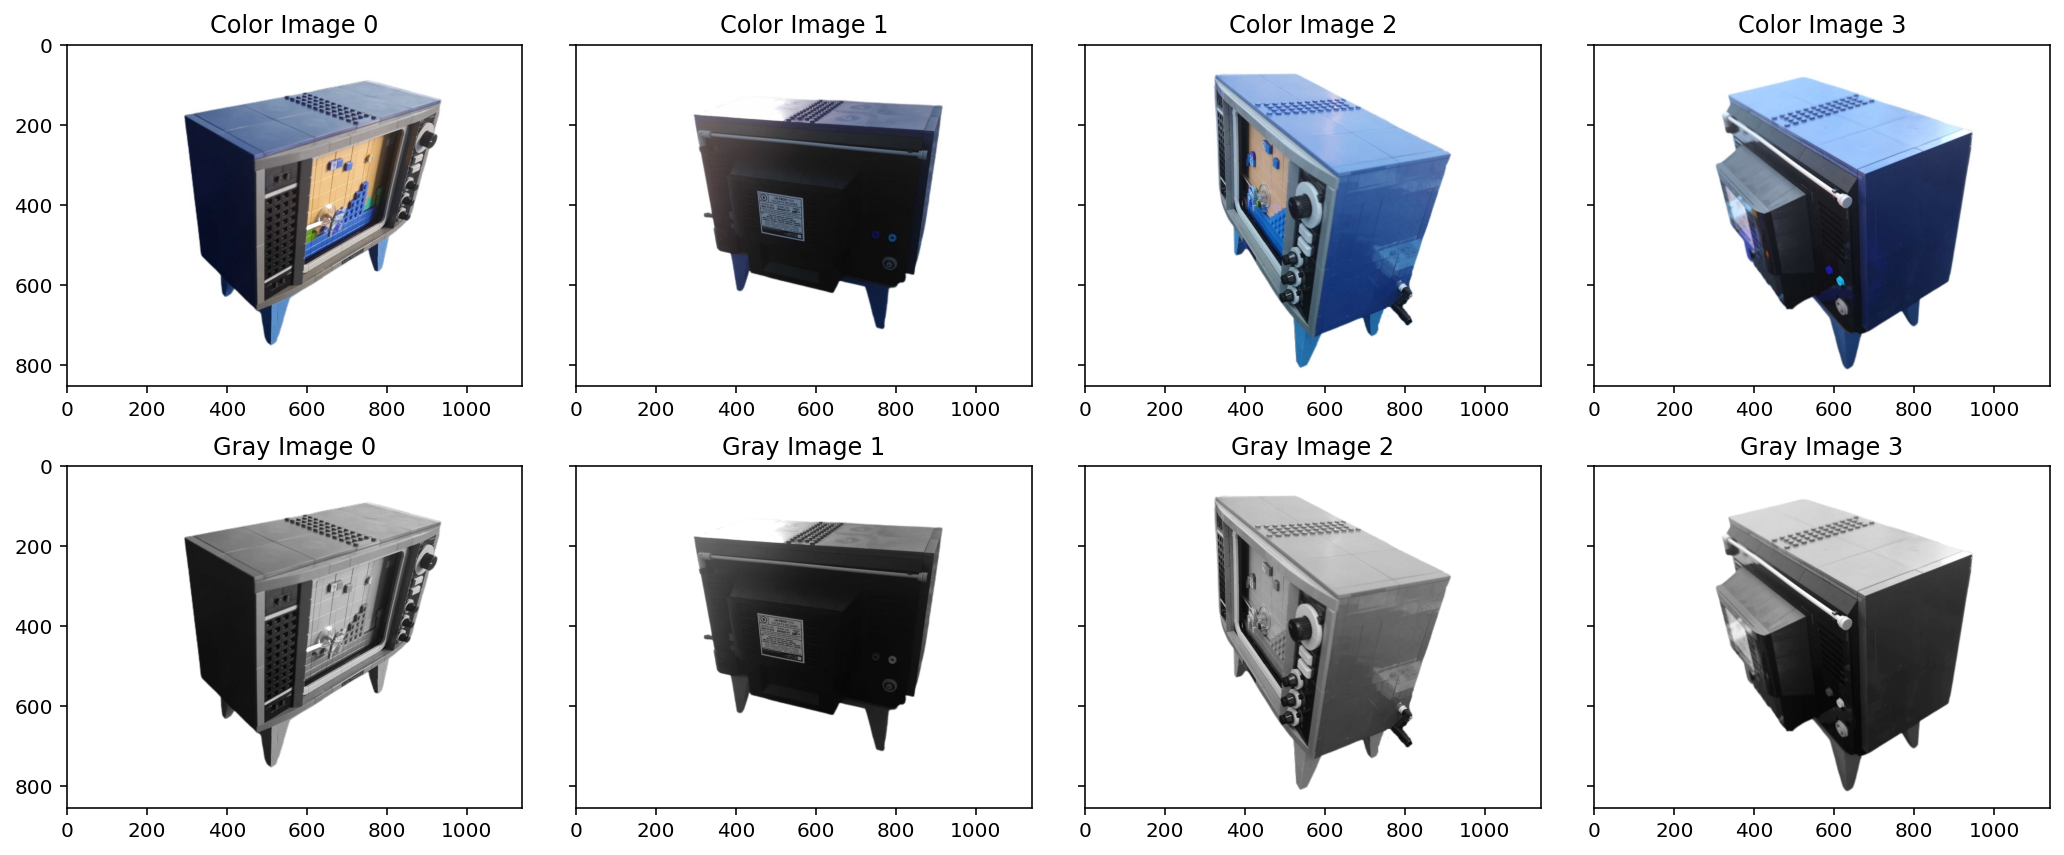

In [4]:
def display_samples(images):
    fig, ax = plt.subplots(2, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(len(images)):
        ax[0, i].set_title('Color Image {}'.format(i))
        ax[0, i].imshow(images[i])
        ax[1, i].set_title('Gray Image {}'.format(i))
        ax[1, i].imshow(gray_images[i], cmap='gray')

display_samples(sample_images)

## Feature Matching


### SIFT Algorithm

#### Detect Feature Points

In [5]:
sift = cv2.SIFT_create()

feature_points = []
descriptors = []
sift_time_ms = []

for gray_image in gray_images:
    b = datetime.datetime.now()
    kps, des = sift.detectAndCompute(gray_image, None)
    e = datetime.datetime.now()
    
    sift_time_ms.append((e - b).microseconds / 1000)
    feature_points.append(kps)
    descriptors.append(des)

sift_time_ms

[101.697, 75.174, 76.824, 77.85]

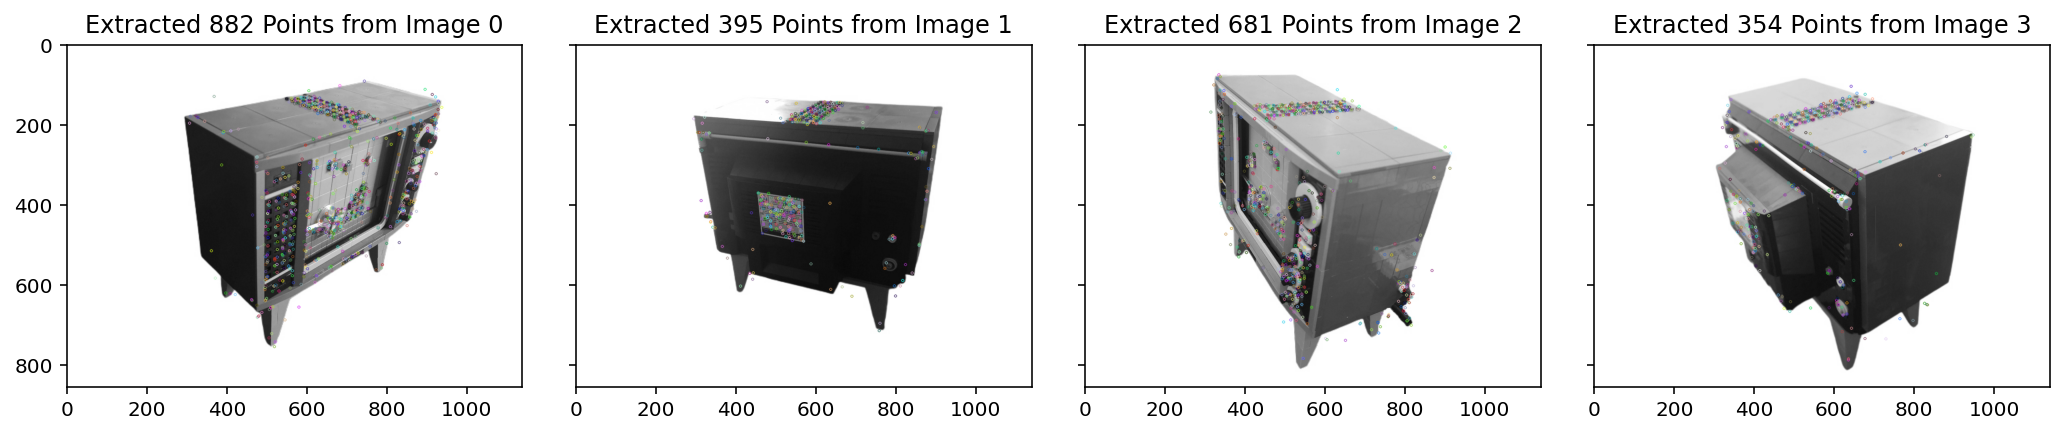

In [6]:
sift_points_count = []

def display_feature_points(images, points):
    fig, ax = plt.subplots(1, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(0, len(images)):
        sift_points_count.append(len(feature_points[i]))
        ax[i].set_title('Extracted {} Points from Image {}'.format(len(feature_points[i]), i))
        image_with_points = cv2.drawKeypoints(images[i], points[i], None)
        ax[i].imshow(image_with_points)

display_feature_points(gray_images, feature_points)

#### Matching Feature Points using FLANN

In [7]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
flann_matches =[]
flann_good_matches = []
flann_time_ms = []

# ratio test as per Lowe's paper
ratio_thresh = 0.8

for (i, j) in gray_image_index_pairs:
    good_matches = []

    b = datetime.datetime.now()
    matches = flann_matcher.knnMatch(descriptors[i], descriptors[j], k=2)
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    e = datetime.datetime.now()
    
    flann_time_ms.append((e - b).microseconds / 1000)
    flann_matches.append(matches)
    flann_good_matches.append(good_matches)

flann_time_ms

[13.149,
 18.298,
 9.39,
 10.098,
 7.686,
 4.638,
 17.165,
 8.488,
 7.655,
 9.029,
 4.137,
 7.334]

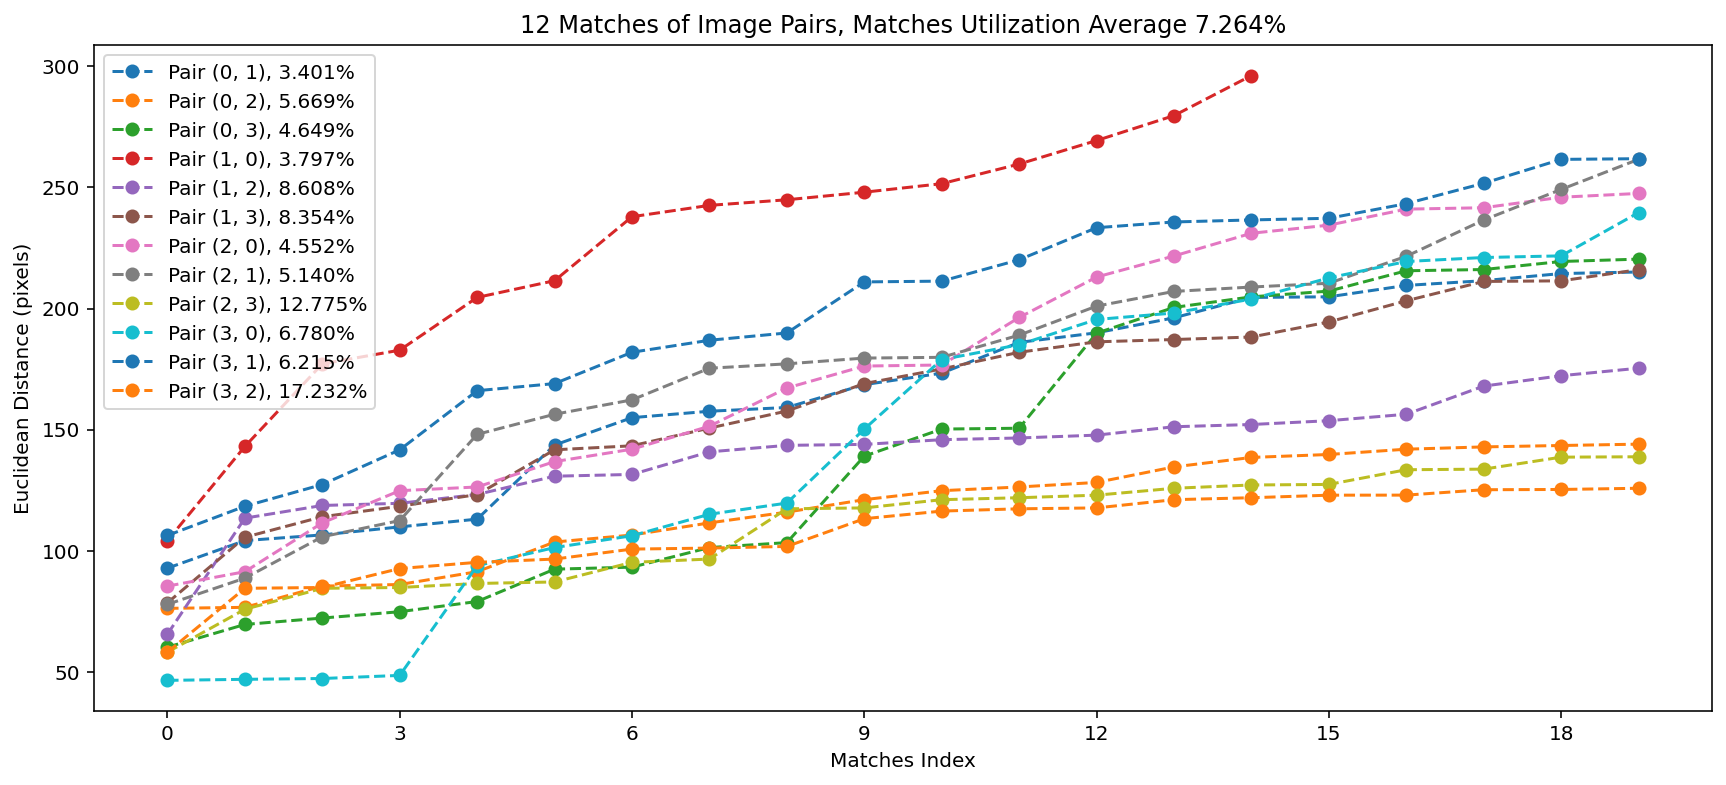

In [8]:
flann_matches_count = [(len(gm), len(am)) for (gm, am) in zip(flann_good_matches, flann_matches)]

def display_matches_quality(index_pairs, good_matches, all_matches, n=20):
    good_matches_sorted = [sorted(gm, key=lambda val: val.distance) for gm in good_matches]
    distances = [[m.distance for m in gm_sorted] for gm_sorted in good_matches_sorted]
    percentages = [(len(gm_sorted) / len(am)) for (gm_sorted, am) in zip(good_matches_sorted, all_matches)]
    
    plt.figure(figsize=(14.5, 6), dpi=plot_dpi)
    plt.title('{} Matches of Image Pairs, Matches Utilization Average {:.3f}%'.format(len(good_matches), np.average(percentages) * 100))
    plt.xticks(range(0, n, 3))
    plt.xlabel('Matches Index')
    plt.ylabel('Euclidean Distance (pixels)')

    for (ip, y, p) in zip(index_pairs, distances, percentages):
        x = np.arange(0, len(y))
        plt.plot(x[:n], y[:n], linestyle='--', marker='o', label='Pair {}, {:.3f}%'.format(ip, p * 100))
        plt.legend()

display_matches_quality(gray_image_index_pairs, flann_good_matches, flann_matches)


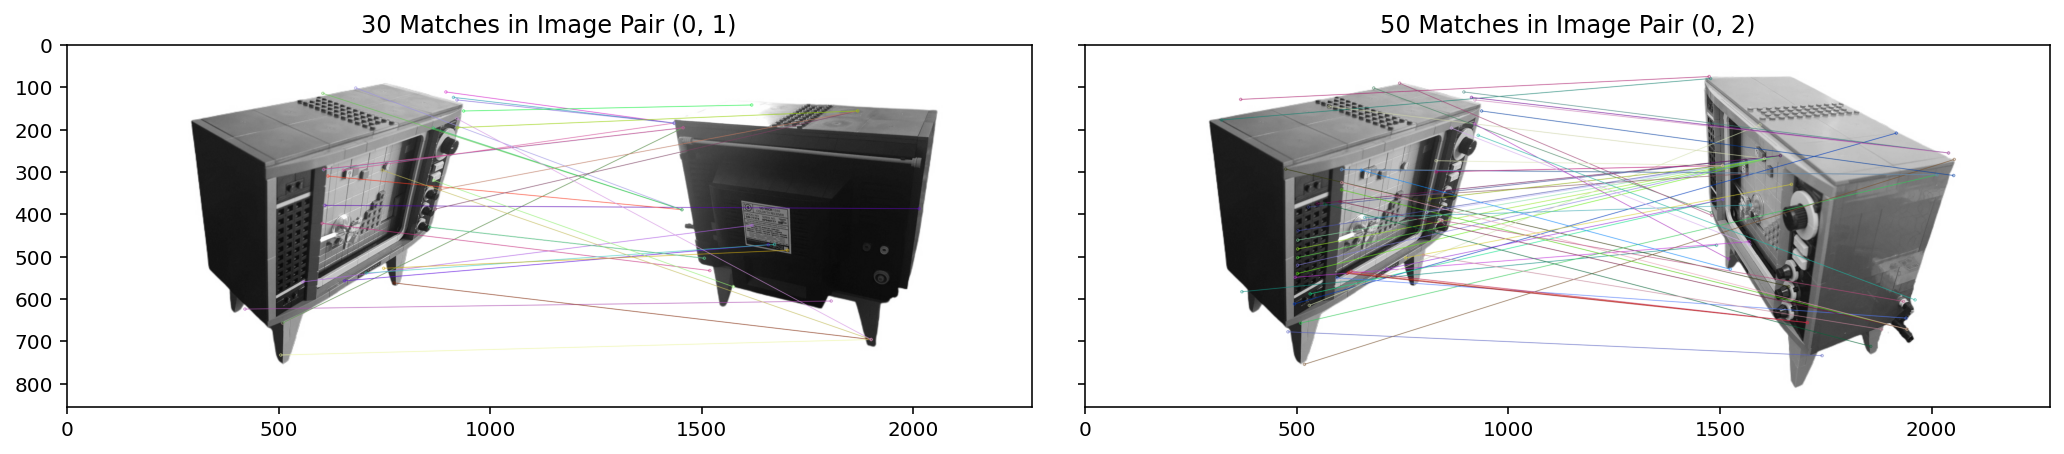

In [9]:
def display_matches(index_pairs, gray_images, feature_points, good_matches, n=2):
    fig, ax = plt.subplots(1, n, figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for ((i, j), k) in zip(index_pairs[:n], range(0, n)):
        stitch_image = np.empty(
            (max(gray_images[i].shape[0], gray_images[j].shape[0]), gray_images[i].shape[1] + gray_images[j].shape[1], 3),
            dtype=np.uint8
        )

        cv2.drawMatches(
            gray_images[i], feature_points[i],
            gray_images[j], feature_points[j],
            good_matches[k], stitch_image,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        ax[k].set_title('{} Matches in Image Pair {}'.format(len(good_matches[k]), (i, j)))
        ax[k].imshow(stitch_image)

display_matches(gray_image_index_pairs, gray_images, feature_points, flann_good_matches)


### SuperPoint + SuperGlue

#### Detect Feature Points using SuperPoint

In [10]:
import matplotlib.cm as cm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))

Running inference on device "cpu"


In [11]:
from thirdparty.SuperPointPretrainedNetwork.superpoint import SuperPoint

superpoint_conf = {
    'descriptor_dim': 256,
    'nms_radius': 3,
    'max_keypoints': 4096,
    'keypoints_threshold': 0.6
}

sp_model = SuperPoint(superpoint_conf)
sp_model.eval()

SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

In [12]:
pretrained_sp_model = torch.load(
    'thirdparty/SuperPointPretrainedNetwork/superpoint_v1.pth',
    map_location=device
)
sp_model.load_state_dict(pretrained_sp_model, strict=True)

<All keys matched successfully>

In [13]:
sp_dummpy_input = np.random.random_sample((1, 1, gray_images[0].shape[0], gray_images[0].shape[1])).astype(np.float32)
_ = sp_model(torch.from_numpy(sp_dummpy_input).to(device))

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [14]:
def normalize_to_tensor(image):
    normalized = image.astype('float32') / 255.
    tensor = torch.from_numpy(normalized).to(device).unsqueeze(0).unsqueeze(0)
    return tensor

normalized_gray_images = [normalize_to_tensor(img) for img in gray_images]

print(gray_images[0].shape)
print(normalized_gray_images[0].shape)

(855, 1140)
torch.Size([1, 1, 855, 1140])


In [15]:
sp_predicts = []
sp_time_ms =[]

for t in normalized_gray_images:
    b = datetime.datetime.now()
    pred = sp_model(t)
    e = datetime.datetime.now()

    sp_time_ms.append((e - b).microseconds / 1000)
    sp_predicts.append(pred)

print(sp_predicts[0].keys())
print(sp_time_ms)

dict_keys(['keypoints', 'scores', 'descriptors'])
[637.954, 643.347, 672.266, 745.779]


In [16]:
keypoints = [p['keypoints'][0].detach().numpy() for p in sp_predicts]
scores = [p['scores'][0].detach().numpy() for p in sp_predicts]

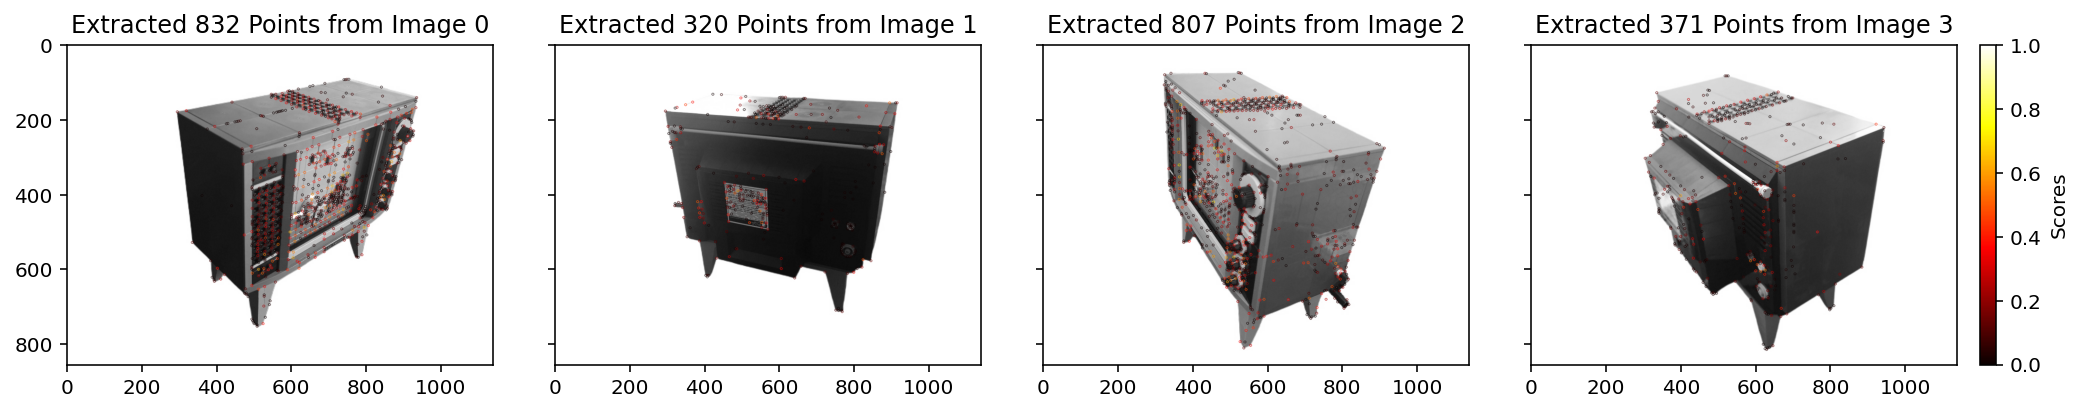

In [17]:
sp_points_count = []

def display_feature_points(images, keypoints, scores):
    fig, ax = plt.subplots(1, len(images), figsize=(16.5, 2.8), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=fig.get_axes(), orientation='vertical', label='Scores', pad=0.01)

    for i in range(0, len(images)):
        out_img = images[i].copy()
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2RGB)
        kpts = np.round(keypoints[i]).astype('int')
        sp_points_count.append(len(kpts))
        
        for (x, y), s in zip(kpts, scores[i]):
            color = (np.array(cm.hot(s)) * 255).astype('uint8')
            cv2.circle(out_img, (x, y), 3, color.tolist(), 1, lineType=cv2.LINE_AA)

        ax[i].set_title('Extracted {} Points from Image {}'.format(len(kpts), i))
        ax[i].imshow(out_img)

display_feature_points(gray_images, keypoints, scores)

#### Matching Feature Point using SuperGlue

In [18]:
from thirdparty.SuperGluePretrainedNetwork.models.superglue import SuperGlue

superglue_conf =  {
    'output': 'matches-spg',
    'conf': {
        'descriptor_dim': 256,
        'weights': 'indoor',
        'match_threshold': 0.7
    }
}

sg_model = SuperGlue(superglue_conf)
sg_model.eval()

Loaded SuperGlue model ("indoor" weights)


SuperGlue(
  (kenc): KeypointEncoder(
    (encoder): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (gnn): AttentionalGNN(
    (layers): ModuleList(
      (0): AttentionalPropagation(
        (attn): MultiHeadedAttention(
          (merge): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    

In [19]:
pretrained_sg_model = torch.load(
    'thirdparty/SuperGluePretrainedNetwork/models/weights/superglue_{}.pth'.format(superglue_conf['conf']['weights']),
    map_location=device
)
sg_model.load_state_dict(pretrained_sg_model, strict=True)

<All keys matched successfully>

In [20]:
gray_images[0].shape

(855, 1140)

In [21]:
def generate_sg_data(index_pairs, gray_images, sp_predicts):
    i, j = index_pairs
    feats0, feats1 = sp_predicts[i], sp_predicts[j]
    img_size0, img_size1 = gray_images[i].shape, gray_images[j].shape
    data = {}

    for k in feats0.keys():
        data[k + '0'] = feats0[k][0]
    for k in feats1.keys():
        data[k + '1'] = feats1[k][0]

    data['image0'] = torch.empty((1, 1, ) + tuple(img_size0)[:-1]).to(device)
    data['image1'] = torch.empty((1, 1, ) + tuple(img_size1)[:-1]).to(device)
    data = {k: v[None].float() for k, v in data.items()}

    return data
    
sg_datas = [generate_sg_data(p, gray_images, sp_predicts) for p in gray_image_index_pairs]

In [22]:
sg_predicts = []
sg_time_ms = []

for inp in sg_datas:
    b = datetime.datetime.now()
    pred = sg_model(inp)
    e = datetime.datetime.now()

    sg_time_ms.append((e - b).microseconds / 1000)
    sg_predicts.append(pred)
    
sg_time_ms


[264.717,
 565.733,
 452.188,
 298.706,
 295.501,
 175.384,
 676.288,
 347.663,
 422.59,
 411.457,
 375.547,
 624.668]

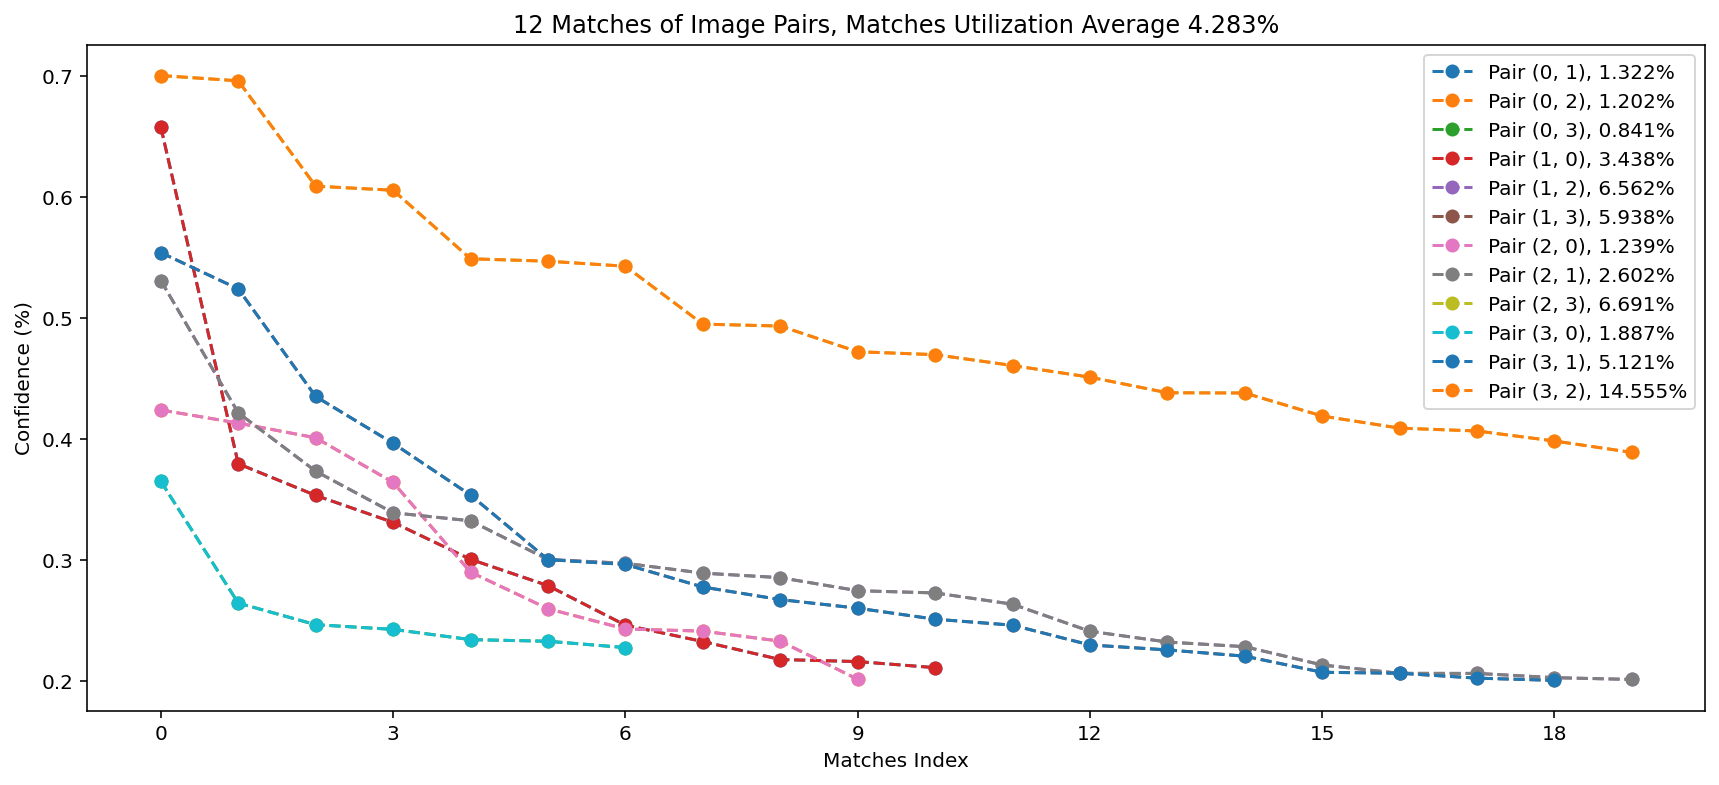

In [23]:
sg_matches_count = []

def display_matches_scores(index_pairs, sg_predicts, n=20):
    percentages = []

    plt.figure(figsize=(14.5, 6), dpi=plot_dpi)
    plt.xticks(range(0, n, 3))
    plt.xlabel('Matches Index')
    plt.ylabel('Confidence (%)')

    for ((i, j), pred) in zip(index_pairs, sg_predicts):
        matches = pred['matches0'][0].detach().numpy()
        valid = matches > -1
        valid_scores = pred['matching_scores0'][0].detach().numpy()[valid]
        valid_scores_sorted = sorted(valid_scores, reverse=True)
        percentage = len(valid_scores_sorted) / len(matches)
        sg_matches_count.append((len(valid_scores), len(matches)))

        percentages.append(percentage)

        x = np.arange(0, len(valid_scores_sorted))
        y = valid_scores_sorted

        plt.plot(x[:n], y[:n], linestyle='--', marker='o', label='Pair {}, {:.3f}%'.format((i, j), percentage * 100))
        plt.legend()

    plt.title('{} Matches of Image Pairs, Matches Utilization Average {:.3f}%'.format(len(sg_predicts), np.average(percentages) * 100))

display_matches_scores(gray_image_index_pairs, sg_predicts)

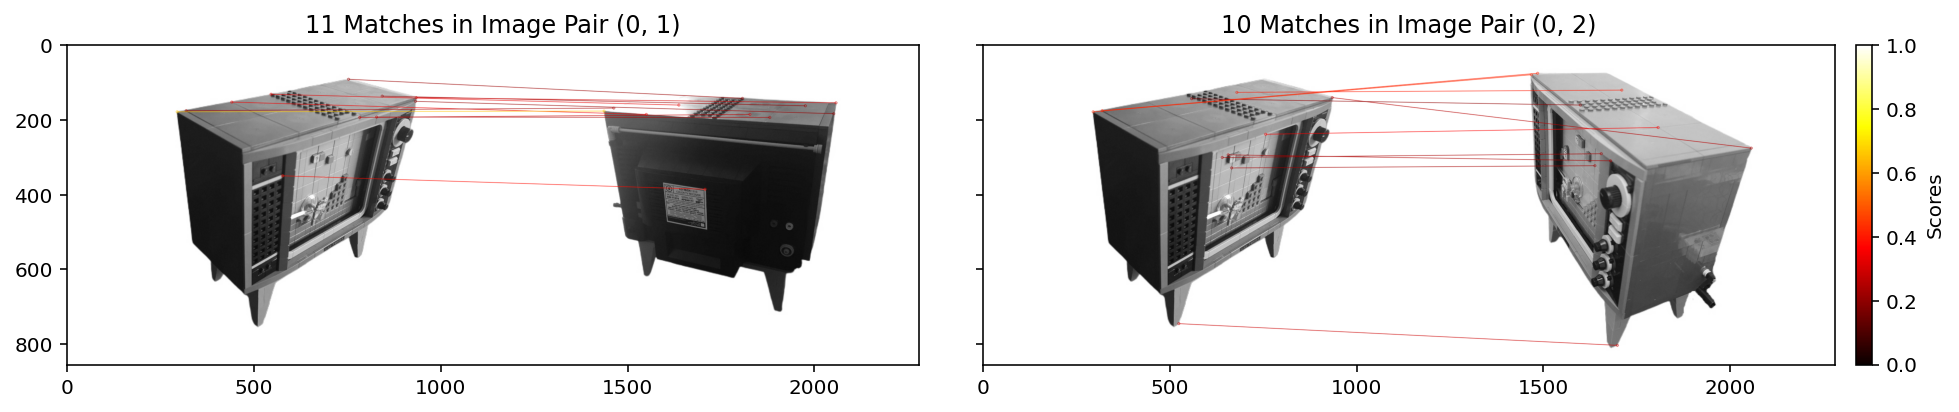

In [24]:
def display_matches(index_pairs, gray_images, sp_predicts, sg_predicts, n=2):
    fig, ax = plt.subplots(1, n, figsize=(15.5, 2.8), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=fig.get_axes(), orientation='vertical', label='Scores', pad=0.01)

    for ((i, j), sg_pred, k) in zip(index_pairs[:n], sg_predicts[:n], range(0, n)):
        matches = sg_pred['matches0'][0].detach().numpy()
        valid = matches > -1

        feats0, feats1 = sp_predicts[i], sp_predicts[j]
        kpts0, kpts1 = feats0['keypoints'][0].__array__(), feats1['keypoints'][0].__array__()
        mkpts0, mkpts1 = np.round(kpts0[valid]).astype('int'), np.round(kpts1[matches[valid]]).astype('int')

        valid_scores = sg_pred['matching_scores0'][0].detach().numpy()[valid]
        percentage = len(valid_scores) / len(matches)

        (h0, w0), (h1, w1) = gray_images[i].shape, gray_images[j].shape
        stitch_image = np.empty((max(h0, h1), w0 + w1), dtype=np.uint8)
        stitch_image[:h0, :w0] = gray_images[i]
        stitch_image[:h1, w0:] = gray_images[j]
        stitch_image = cv2.cvtColor(stitch_image, cv2.COLOR_GRAY2RGB)

        for (x0, y0), (x1, y1), s in zip(mkpts0, mkpts1, valid_scores):
            color = (np.array(cm.hot(s)) * 255).astype('uint8')

            cv2.line(stitch_image, (x0, y0), (x1 + w0, y1), color.tolist(), thickness=1, lineType=cv2.LINE_AA)
            cv2.circle(stitch_image, (x0, y0), 3, color.tolist(), 1, lineType=cv2.LINE_AA)
            cv2.circle(stitch_image, (x1 + w0, y1), 3, color.tolist(), 1, lineType=cv2.LINE_AA)
        
        ax[k].set_title('{} Matches in Image Pair {}'.format(len(valid_scores), (i, j)))
        ax[k].imshow(stitch_image)

display_matches(gray_image_index_pairs, gray_images, sp_predicts, sg_predicts)

### Compare

#### Time consumption

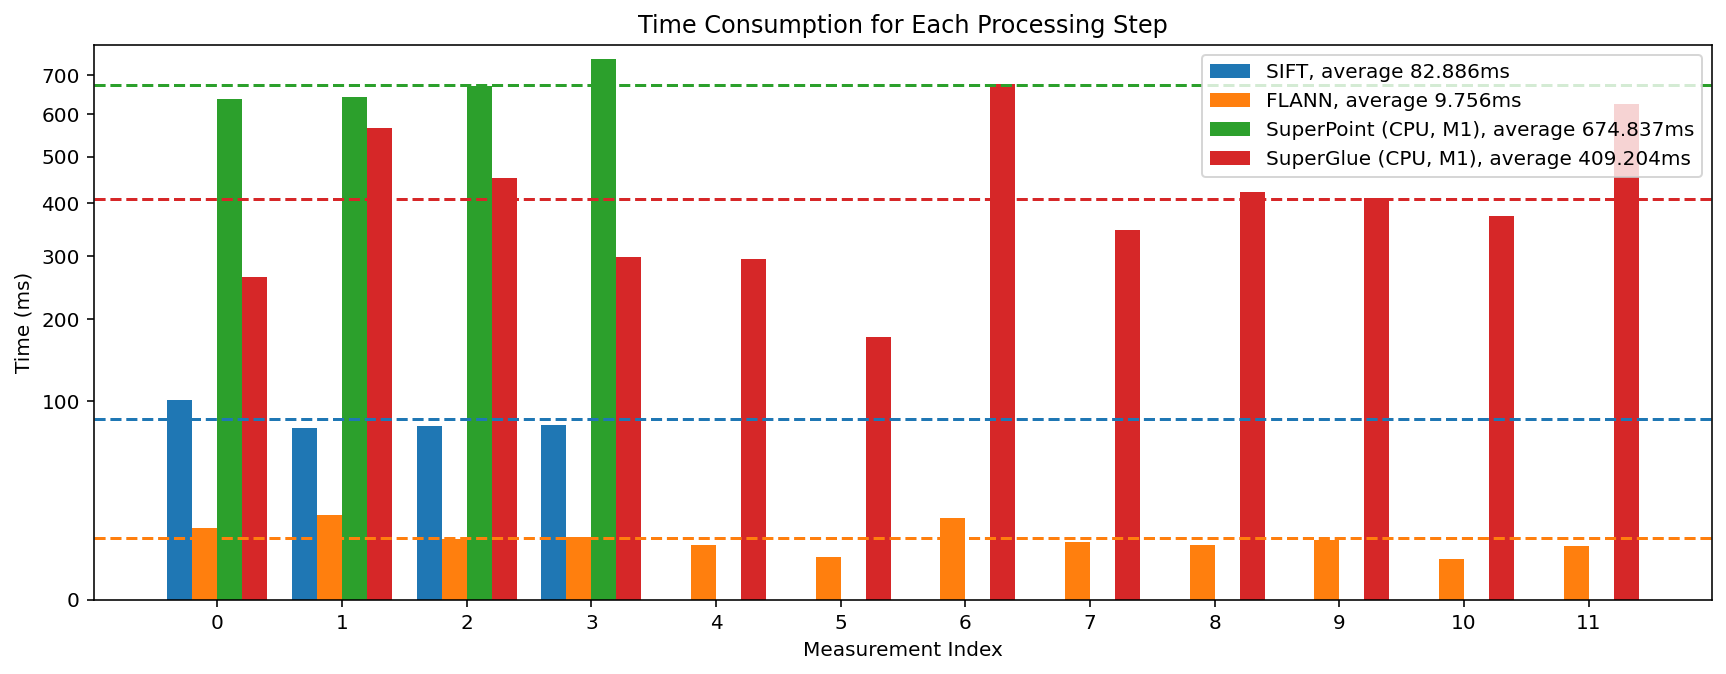

In [25]:
def display_time_consumption(durations_with_name):
    total_width, n = 0.8, len(durations_with_name)
    width = total_width / n
    x_max = 0
    cmap = cm.get_cmap()

    plt.figure(figsize=(14.5, 5), dpi=plot_dpi)
    plt.xlabel('Measurement Index')
    plt.ylabel('Time (ms)')
    plt.title('Time Consumption for Each Processing Step')

    for ((y, t), i) in zip(durations_with_name, range(0, n)):
        x = np.arange(0, len(y))
        x_max = max(len(y), x_max)
        avg = np.average(y)
        color = cmap(y * 255)
        
        bar = plt.bar(x + (i * width - (total_width - width) / 2), y, width=width, label='{}, average {:.3f}ms'.format(t, avg))
        axhline = plt.axhline(avg, color=bar.patches[0].get_facecolor(), linestyle='--')
        plt.legend()

    plt.xticks(range(0, x_max, 1))
    plt.yscale('function', functions=(lambda v: v ** 0.5, lambda v: v ** 2))

durations_with_name = [
    (sift_time_ms, 'SIFT'),
    (flann_time_ms, 'FLANN'),
    (sp_time_ms, 'SuperPoint (CPU, M1)'),
    (sg_time_ms, 'SuperGlue (CPU, M1)')
]

display_time_consumption(durations_with_name)

#### Feature Points Quantity and Utilization

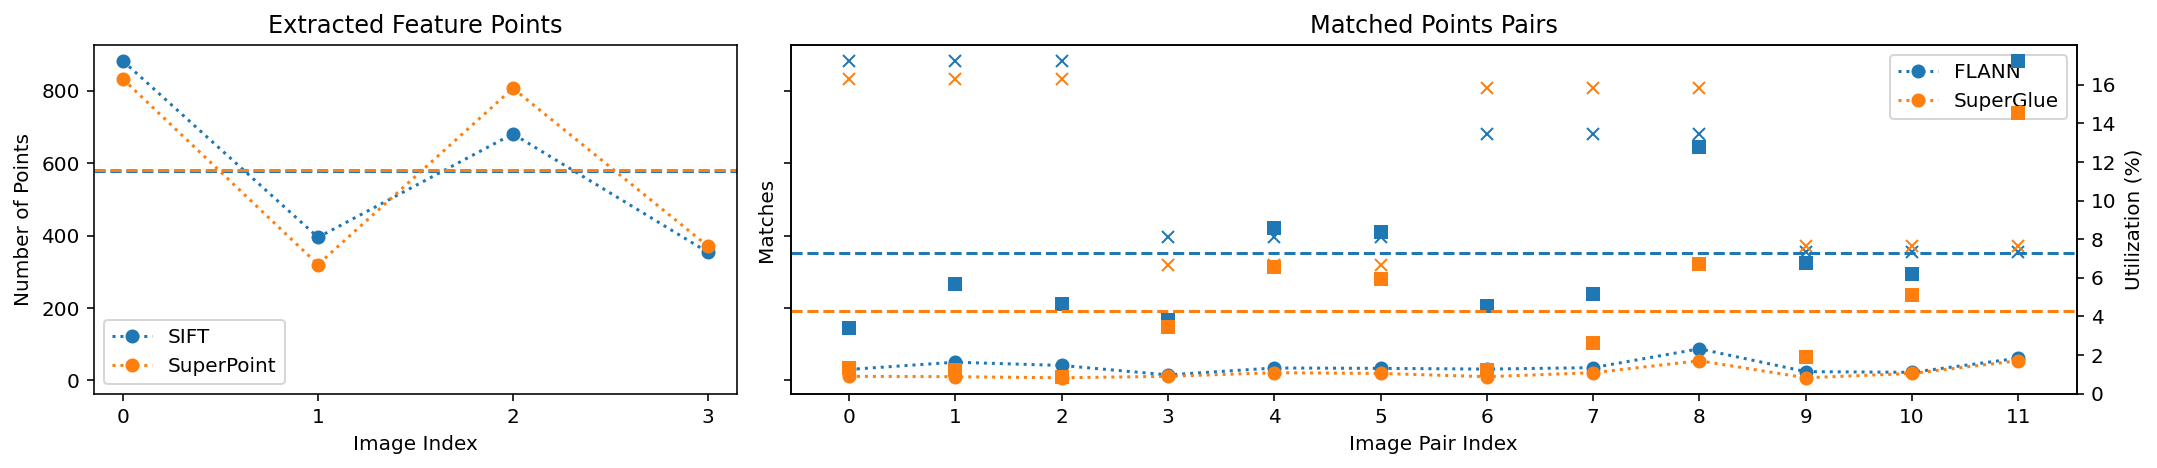

In [26]:
def display_quantity_and_utilization(points_counts, matches_counts):
    fig, ax = plt.subplots(1, 2, figsize=(14.5, 3), gridspec_kw={'width_ratios': [1, 2]}, constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    ax[0].set_title('Extracted Feature Points')
    ax[0].set_xticks(range(0, len(points_counts[0][0]), 1))
    ax[0].set_xlabel('Image Index')
    ax[0].set_ylabel('Number of Points')
    for (pc, lb) in points_counts:
        x = range(0, len(pc))
        l = ax[0].plot(x, pc, linestyle=':', marker='o', label=lb)
        h = ax[0].axhline(np.average(pc), color=l[0].get_color(), linestyle='--')
        ax[0].legend()

    ax[1].set_title('Matched Points Pairs')
    ax[1].set_xlabel('Image Pair Index')
    ax[1].set_xticks(range(0, len(matches_counts[0][0]), 1))
    ax[1].set_ylabel('Matches')
    ax_t = ax[1].twinx()
    ax_t.set_ylabel('Utilization (%)')
    ps_max = 0
    for (mc, lb) in matches_counts:
        x = range(0, len(mc))
        v = [f for (f, _) in mc]
        a = [s for (_, s) in mc]
        ps = [(vc / ac) * 100 for (vc, ac) in zip(v, a)]
        ps_max = ps_max if ps_max > max(ps) else max(ps)
        lv = ax[1].plot(x, v, linestyle=':', marker='o', label=lb)
        la = ax[1].plot(x, a, linestyle='', marker='x', color=lv[0].get_color())
        lp = ax_t.plot(x, ps, linestyle='', marker='s', color=lv[0].get_color())
        lh = ax_t.axhline(np.average(ps), linestyle='--', color=lv[0].get_color())
        ax[1].legend()
    ax_t.set_yticks(range(0, int(ps_max), 2))

points_counts = [
    (sift_points_count, 'SIFT'),
    (sp_points_count, 'SuperPoint')
]
matches_counts = [
    (flann_matches_count, 'FLANN'),
    (sg_matches_count, 'SuperGlue')
]

display_quantity_and_utilization(points_counts, matches_counts)

#### Comparison of Future Points Extracting and Matching

In [39]:
homography_estimation = {
    'SIFT': {
        '1': 0.63,
        '3': 0.76,
        '5': 0.79
    },
    'SuperPoint (Pretrained)': {
        '1': 0.44,
        '3': 0.77,
        '5': 0.83
    },
    'SuperPoint (COCO)': {
        '1': 0.46,
        '3': 0.75,
        '5': 0.81
    }
}

detector_metric = {
    'SIFT': {
        'Repeatability': 0.51,
        'MLE': 1.16
    },
    'SuperPoint (Pretrained)': {
        'Repeatability': 0.61,
        'MLE': 1.14
    },
    'SuperPoint (COCO)': {
        'Repeatability': 0.63,
        'MLE': 1.07
    }
}

descriptor_metric = {
    'SIFT': {
        'NN mAP': 0.80,
        'Matching Score': 0.27
    },
    'SuperPoint (Pretrained)': {
        'NN mAP': 0.81,
        'Matching Score': 0.55
    },
    'SuperPoint (COCO)': {
        'NN mAP': 0.78,
        'Matching Score': 0.42
    }
}

# From https://github.com/eric-yyjau/pytorch-superpoint

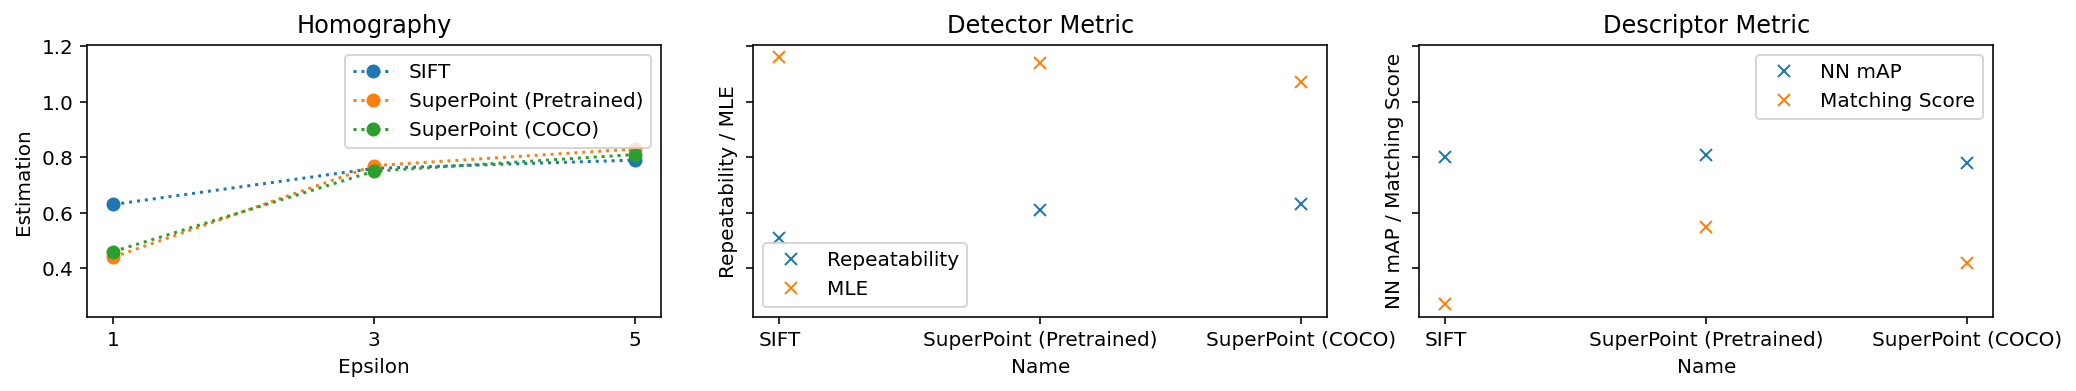

In [91]:
def display_overall_quality(homography, detector, descriptor):
    fig, ax = plt.subplots(1, 3, figsize=(14.5, 3), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout(pad=3)

    ax[0].set_title('Homography')
    ax[0].set_xlabel('Epsilon')
    ax[0].set_ylabel('Estimation')
    for (k, v) in homography.items():
        y = [e for (_, e) in v.items()]
        x = [e for (e, _) in v.items()]
        ax[0].plot(x, y, linestyle=':', marker='o', label=k)
        ax[0].legend()

    ax[1].set_title('Detector Metric')
    ax[1].set_xlabel('Name')
    ax[1].set_ylabel('Repeatability / MLE')
    x = [n for (n, _) in detector.items()]
    ys = {
        'Repeatability': [p['Repeatability'] for (_, p) in detector.items()],
        'MLE': [p['MLE'] for (_, p) in detector.items()]
    }
    for (k, y) in ys.items():
        ax[1].plot(x, y, linestyle='', marker='x', label=k)
        ax[1].legend()
    
    ax[2].set_title('Descriptor Metric')
    ax[2].set_xlabel('Name')
    ax[2].set_ylabel('NN mAP / Matching Score')
    ys = {
        'NN mAP': [p['NN mAP'] for (_, p) in descriptor.items()],
        'Matching Score': [p['Matching Score'] for (_, p) in descriptor.items()]
    }
    for (k, y) in ys.items():
        ax[2].plot(x, y, linestyle='', marker='x', label=k)
        ax[2].legend()


display_overall_quality(homography_estimation, detector_metric, descriptor_metric)